Import

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

Load Image

In [ ]:
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError("Image path does not exist.")
    image = Image.open(image_path).convert("RGB")
    return image


PreProcessing

In [ ]:
def preprocess_image(image, is_training=True, target_size=(224, 224)):
    transform_list = []

    transform_list.append(transforms.Resize(target_size))
    transform_list.append(transforms.ToTensor())

    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std  = [0.229, 0.224, 0.225]
    transform_list.append(transforms.Normalize(mean=imagenet_mean, std=imagenet_std))
    #data argumentation
    if is_training:
        aug_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomResizedCrop(target_size, scale=(0.8, 1.0)),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ])
        image = aug_transforms(image)
    preprocess_pipeline = transforms.Compose(transform_list)
    return preprocess_pipeline(image)


Normalize

In [ ]:
def show_tensor_image(tensor_image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = tensor_image * std + mean
    img = img.permute(1, 2, 0).numpy()  # CHW to HWC
    plt.imshow(np.clip(img, 0, 1))
    plt.axis("off")
    plt.show()

Preprocessed image shape: torch.Size([3, 224, 224])


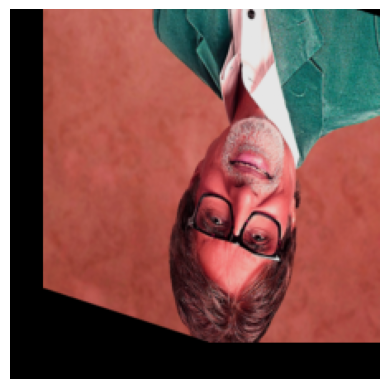

In [ ]:
if __name__ == "__main__":
    image_path = "/content/image.jpg"
    raw_image = load_image(image_path)
    processed_image = preprocess_image(raw_image, is_training=True)
    print("Preprocessed image shape:", processed_image.shape)

    show_tensor_image(processed_image)

Model Specific

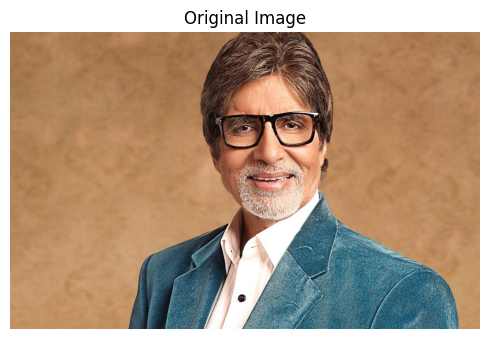

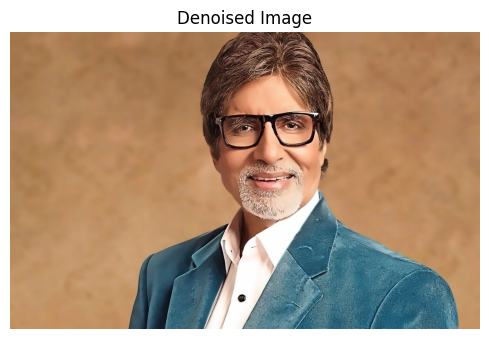

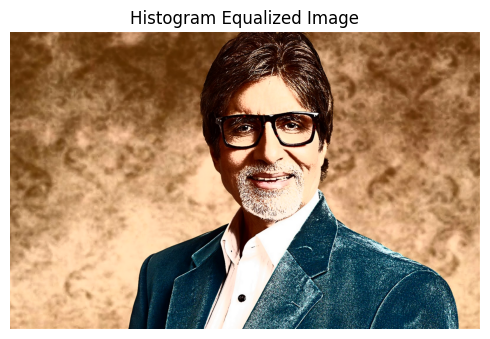

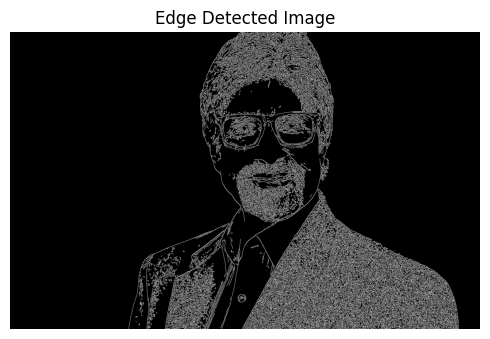

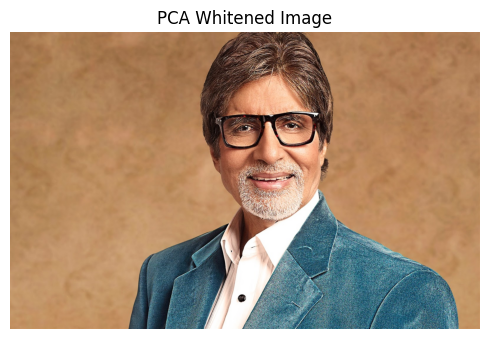

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError("Image not found!")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def apply_denoising(img):
    return cv2.fastNlMeansDenoisingColored(img, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

# Histogram Equalization (on each channel)
def apply_histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

# Edge Detection (Canny)
def apply_edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges

# PCA Whitening
def apply_pca_whitening(img):
    # Flatten and normalize
    img_flat = img.reshape(-1, 3)
    scaler = StandardScaler()
    img_scaled = scaler.fit_transform(img_flat)

    # PCA whitening
    pca = PCA(whiten=True)
    img_pca = pca.fit_transform(img_scaled)

    # Inverse transform to original shape and rescale to 0-255
    img_pca_inv = scaler.inverse_transform(pca.inverse_transform(img_pca))
    img_pca_img = img_pca_inv.reshape(img.shape).astype(np.uint8)
    return img_pca_img

def display_and_save(title, img, cmap=None):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.axis('off')
    plt.imshow(img, cmap=cmap)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

if __name__ == "__main__":
    path = "image.jpg"
    img = load_image(path)

    denoised = apply_denoising(img)
    equalized = apply_histogram_equalization(img)
    edges = apply_edge_detection(img)
    pca_img = apply_pca_whitening(img)

    display_and_save("Original Image", img)
    display_and_save("Denoised Image", denoised)
    display_and_save("Histogram Equalized Image", equalized)
    display_and_save("Edge Detected Image", edges, cmap="gray")
    display_and_save("PCA Whitened Image", pca_img)


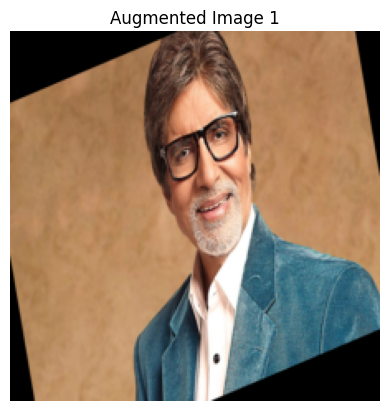

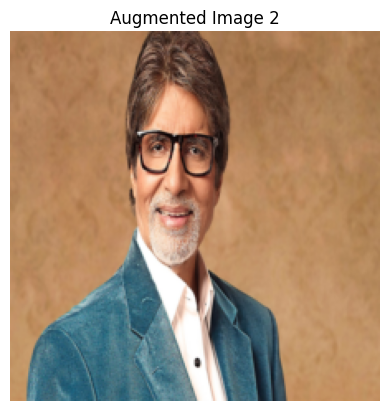

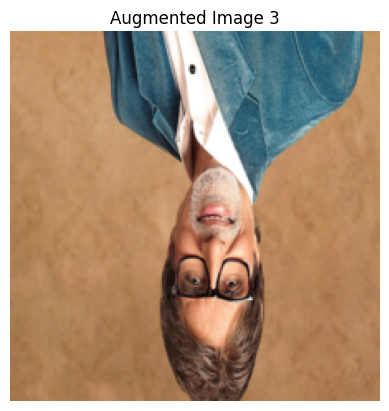

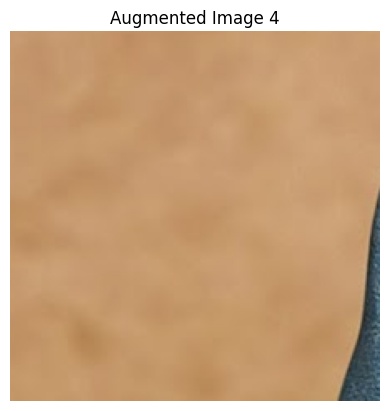

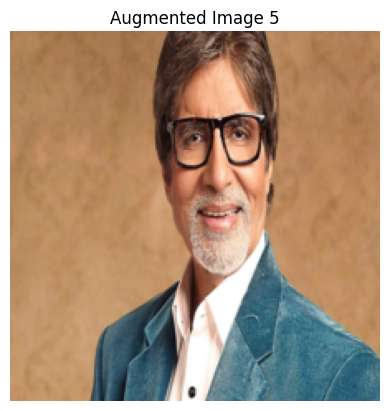

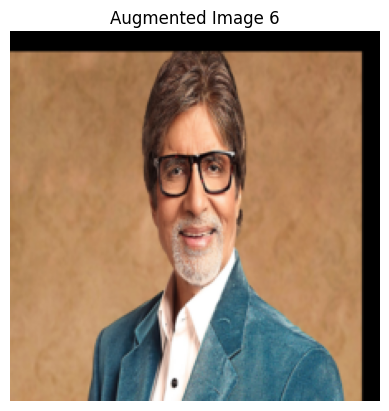

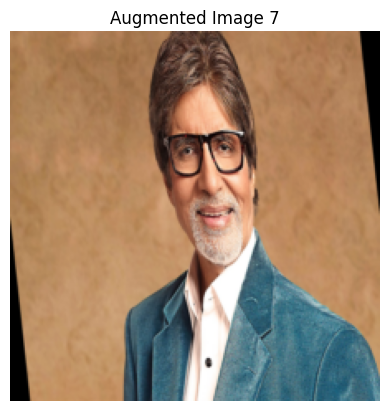

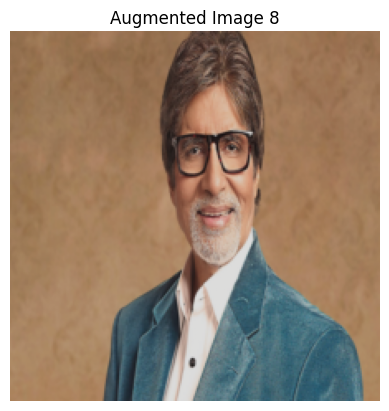

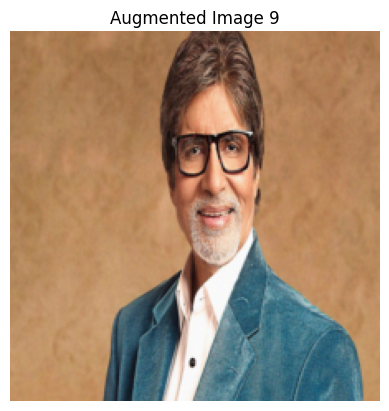

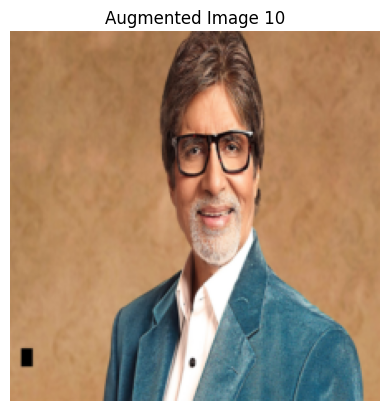

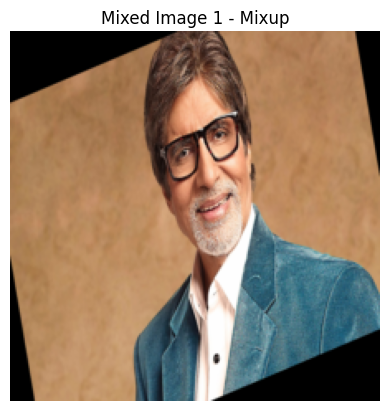

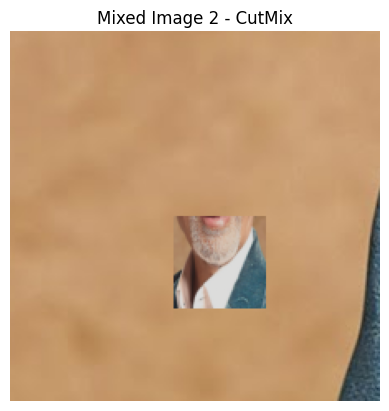

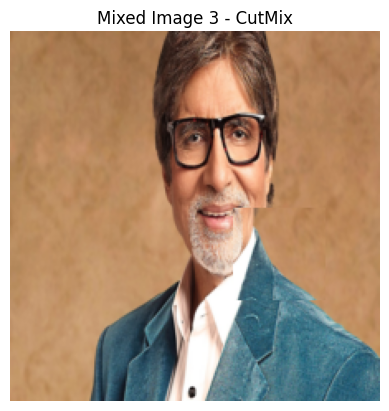

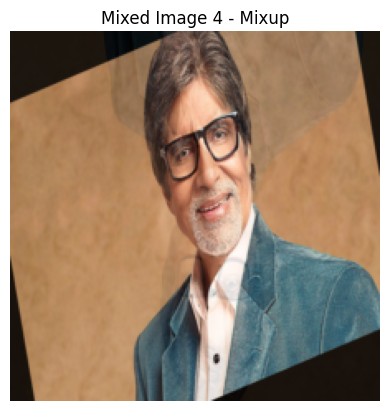

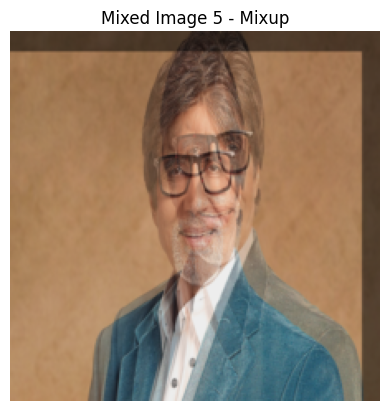

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError("Image path does not exist.")
    image = Image.open(image_path).convert("RGB")
    return image

# Augmentations as separate functions:

def rotate(image, angle=15):
    return F.rotate(image, angle)

def flip_horizontal(image):
    return F.hflip(image)

def flip_vertical(image):
    return F.vflip(image)

def random_crop(image, size=(224, 224)):
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=size)
    return F.crop(image, i, j, h, w)

def zoom(image, scale=1.2):
    w, h = image.size
    new_w, new_h = int(w / scale), int(h / scale)
    left = (w - new_w) // 2
    top = (h - new_h) // 2
    image_cropped = F.crop(image, top, left, new_h, new_w)
    return F.resize(image_cropped, (h, w))

def translate(image, max_translate=0.1):
    w, h = image.size
    max_dx = int(w * max_translate)
    max_dy = int(h * max_translate)
    translations = (random.randint(-max_dx, max_dx), random.randint(-max_dy, max_dy))
    return F.affine(image, angle=0, translate=translations, scale=1, shear=0)

def shear(image, max_shear=10):
    shear_val = random.uniform(-max_shear, max_shear)
    return F.affine(image, angle=0, translate=(0, 0), scale=1, shear=shear_val)

def brightness_contrast(image, brightness=0.2, contrast=0.2):
    image = F.adjust_brightness(image, 1 + random.uniform(-brightness, brightness))
    image = F.adjust_contrast(image, 1 + random.uniform(-contrast, contrast))
    return image

def gaussian_noise(image, mean=0, std=0.05):
    np_img = np.array(image).astype(np.float32) / 255.0
    noise = np.random.normal(mean, std, np_img.shape)
    np_img = np_img + noise
    np_img = np.clip(np_img, 0, 1) * 255
    return Image.fromarray(np_img.astype(np.uint8))

def cutout(image, size=50):
    np_img = np.array(image)
    h, w, _ = np_img.shape
    x = random.randint(0, w - size)
    y = random.randint(0, h - size)
    np_img[y:y+size, x:x+size, :] = 0
    return Image.fromarray(np_img)

# Convert PIL Image to tensor and normalize
def preprocess_image(image, target_size=(224, 224)):
    transform_list = [
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
    preprocess_pipeline = transforms.Compose(transform_list)
    return preprocess_pipeline(image)

# Mixup augmentation
def mixup(image1, image2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    return lam * image1 + (1 - lam) * image2

# CutMix augmentation
def cutmix(image1, image2):
    _, H, W = image1.shape
    cx = random.randint(W // 4, 3 * W // 4)
    cy = random.randint(H // 4, 3 * H // 4)
    cut_w = W // 4
    cut_h = H // 4

    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    new_image = image1.clone()
    new_image[:, y1:y2, x1:x2] = image2[:, y1:y2, x1:x2]
    return new_image

# Show tensor image (unnormalize and plot)
def show_tensor_image(tensor_image, title=None):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = tensor_image * std + mean
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

if __name__ == "__main__":
    image_path = "image.jpg"
    raw_image = load_image(image_path)

    augmented_images = []
    augmented_images.append(rotate(raw_image, 15))
    augmented_images.append(flip_horizontal(raw_image))
    augmented_images.append(flip_vertical(raw_image))
    augmented_images.append(random_crop(raw_image))
    augmented_images.append(zoom(raw_image))
    augmented_images.append(translate(raw_image))
    augmented_images.append(shear(raw_image))
    augmented_images.append(brightness_contrast(raw_image))
    augmented_images.append(gaussian_noise(raw_image))
    augmented_images.append(cutout(raw_image))

    for i, img in enumerate(augmented_images):
        show_tensor_image(preprocess_image(img), title=f"Augmented Image {i+1}")

    tensor_images = [preprocess_image(img) for img in augmented_images]

    #------------------------------------------------------------------------------------#

    mixed_images = []
    for i in range(5):
        img1, img2 = random.sample(tensor_images, 2)
        if random.random() < 0.5:
            mixed = mixup(img1, img2)
            method = "Mixup"
        else:
            mixed = cutmix(img1, img2)
            method = "CutMix"
        mixed_images.append((mixed, method))

    #------------------------------------------------------------------------------------#

    for i, (img, method) in enumerate(mixed_images):
        show_tensor_image(img, title=f"Mixed Image {i+1} - {method}")
